In [2]:
# Core
import os
import importlib
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Model / Feature selection / Scaling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, LinearSVC

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

# Saving Model
import joblib


In [3]:
df2=pd.read_csv('BRCA_clinicalMatrix.gz',compression='gzip',sep='\t',index_col=0)
df2.index = pd.Series({x: x.replace('-', '-') for x in df2.index})
print("Clinical Data Before:", df2.shape)
k=df2.columns.get_loc('PAM50Call_RNAseq')
df2=df2[df2.iloc[:,k].isna()==False]
df2.head()

Clinical Data Before: (1247, 202)


,AJCC_Stage_nature2012,Age_at_Initial_Pathologic_Diagnosis_nature2012,CN_Clusters_nature2012,Converted_Stage_nature2012,Days_to_Date_of_Last_Contact_nature2012,Days_to_date_of_Death_nature2012,ER_Status_nature2012,Gender_nature2012,HER2_Final_Status_nature2012,Integrated_Clusters_no_exp__nature2012,...,_GENOMIC_ID_TCGA_BRCA_mutation_wustl_gene,_GENOMIC_ID_TCGA_BRCA_miRNA_GA,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_GA_gene,_GENOMIC_ID_TCGA_BRCA_gistic2thd,_GENOMIC_ID_data/public/TCGA/BRCA/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,_GENOMIC_ID_TCGA_BRCA_gistic2,_GENOMIC_ID_TCGA_BRCA_PDMarray
TCGA-A1-A0SB-01,Stage I,70.0,1.0,Stage I,259.0,NaN,Positive,FEMALE,Negative,NaN,...,TCGA-A1-A0SB-01A-11D-A142-09,NaN,a2405d64-34eb-4915-abf7-8530151d5cb0,NaN,TCGA-A1-A0SB-01A-11D-A141-01,TCGA-A1-A0SB-01,NaN,a2405d64-34eb-4915-abf7-8530151d5cb0,TCGA-A1-A0SB-01A-11D-A141-01,NaN
TCGA-A1-A0SD-01,Stage IIA,59.0,2.0,Stage IIA,437.0,NaN,Positive,FEMALE,Negative,NaN,...,TCGA-A1-A0SD-01A-11D-A10Y-09,NaN,15bad71d-3031-413b-9e8d-6426ae5dfbea,NaN,TCGA-A1-A0SD-01A-11D-A111-01,TCGA-A1-A0SD-01,TCGA-A1-A0SD-01A-11R-A115-07,15bad71d-3031-413b-9e8d-6426ae5dfbea,TCGA-A1-A0SD-01A-11D-A111-01,TCGA-A1-A0SD-01
TCGA-A1-A0SE-01,Stage I,56.0,2.0,Stage I,1320.0,NaN,Positive,FEMALE,Negative,NaN,...,TCGA-A1-A0SE-01A-11D-A099-09,TCGA-A1-A0SE-01,a998e0ce-9248-460f-aabc-2dad452a1ff9,TCGA-A1-A0SE-01,TCGA-A1-A0SE-01A-11D-A087-01,NaN,TCGA-A1-A0SE-01A-11R-A084-07,a998e0ce-9248-460f-aabc-2dad452a1ff9,TCGA-A1-A0SE-01A-11D-A087-01,TCGA-A1-A0SE-01
TCGA-A1-A0SF-01,Stage IIA,54.0,3.0,Stage IIA,1463.0,NaN,Positive,FEMALE,Negative,NaN,...,TCGA-A1-A0SF-01A-11D-A142-09,NaN,28089e15-5e2c-4e83-ba6c-62b3cb40e431,NaN,TCGA-A1-A0SF-01A-11D-A141-01,TCGA-A1-A0SF-01,NaN,28089e15-5e2c-4e83-ba6c-62b3cb40e431,TCGA-A1-A0SF-01A-11D-A141-01,NaN
TCGA-A1-A0SG-01,Stage IIB,61.0,4.0,Stage IIB,433.0,NaN,Positive,FEMALE,Negative,NaN,...,TCGA-A1-A0SG-01A-11D-A142-09,NaN,0df6b948-367d-4951-9d98-d3bebabff63e,NaN,TCGA-A1-A0SG-01A-11D-A141-01,TCGA-A1-A0SG-01,NaN,0df6b948-367d-4951-9d98-d3bebabff63e,TCGA-A1-A0SG-01A-11D-A141-01,NaN


In [6]:

  # gene-level methylation features
y = df2.iloc[:, k].values     # PAM50 labels (from clinical data)

scaler = StandardScaler()


In [8]:
X_train = pd.read_csv('X_train.csv')
X_test  = pd.read_csv('X_test.csv')

y_train = pd.read_csv('Y_train.csv').squeeze("columns")  
y_test  = pd.read_csv('Y_test.csv').squeeze("columns")    # -> Series

# Optional sanity check
print(y_train.value_counts(dropna=False))
print(y_train.dtype)


Label
LumA      230
LumB      102
Normal     70
Basal      70
Her2       24
Name: count, dtype: int64
object


In [15]:
def get_irus_sampling_strategy(y):
    counts = Counter(y)
    majority_class = max(counts, key=counts.get)
    minority_class = min(counts, key=counts.get)
    imbalance_ratio = counts[majority_class] / counts[minority_class]
    
    # IRUS formula: inverse of square root of imbalance ratio
    sampling_ratio = 1 / np.sqrt(imbalance_ratio)
    
    # Calculate number of samples to keep for majority class
    n_samples_majority = int(counts[minority_class] / sampling_ratio)
    
    return {majority_class: n_samples_majority}

# Get IRUS sampling strategy based on training data
irus_strategy = get_irus_sampling_strategy(y_train)

# Define pipeline with IRUS and RFE for SVM
pipelineIrus = ImbPipeline([
    ('irus', RandomUnderSampler(sampling_strategy=irus_strategy, random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # Using SVC as the final classifier
])

In [86]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# RANDOM SEARCH
param_dist = {
    'svm__C': loguniform(1e-3, 1e3),   # ← MUCH better than fixed discrete list
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': loguniform(1e-6, 1e-1)
}

rand = RandomizedSearchCV(
    estimator=pipelineIrus,
    param_distributions=param_dist,
    n_iter=50,                     # you decide budget
    scoring='f1_weighted',
    cv=3,
    n_jobs= 10,
    verbose=1,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
best_model1 = rand.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'svm__C': 0.04449700268707567, 'svm__gamma': 0.0006400547563489189, 'svm__kernel': 'linear'}


In [87]:
import pandas as pd

results_df = pd.DataFrame(rand.cv_results_)

# sort by best score (RandomizedSearch stores mean test score column)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

top10 = results_df.head(10)

cols_to_show = ['mean_test_score', 'param_svm__C', 'param_svm__gamma', 'param_svm__kernel']
print(top10[cols_to_show])


    mean_test_score  param_svm__C  param_svm__gamma param_svm__kernel
35         0.791022      0.044497          0.000640            linear
42         0.787321      0.031315          0.000113            linear
3          0.784889      0.100520          0.000005            linear
0          0.784872      0.176702          0.056698            linear
21         0.784872      0.234910          0.042983            linear
48         0.784872     69.926361          0.030231            linear
45         0.784872      5.573452          0.000030            linear
41         0.784872      2.396919          0.003003            linear
38         0.784872      0.917854          0.000411            linear
30         0.784872     23.661540          0.007184            linear


In [88]:
# Evaluate the model on test data
y_pred = best_model1.predict(X_test)
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))


Test Accuracy (best model): 0.7580645161290323

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.94      0.88      0.91        17
        Her2       0.75      0.86      0.80         7
        LumA       0.92      0.60      0.73        58
        LumB       0.55      0.88      0.68        25
      Normal       0.73      0.94      0.82        17

    accuracy                           0.76       124
   macro avg       0.78      0.83      0.79       124
weighted avg       0.81      0.76      0.76       124



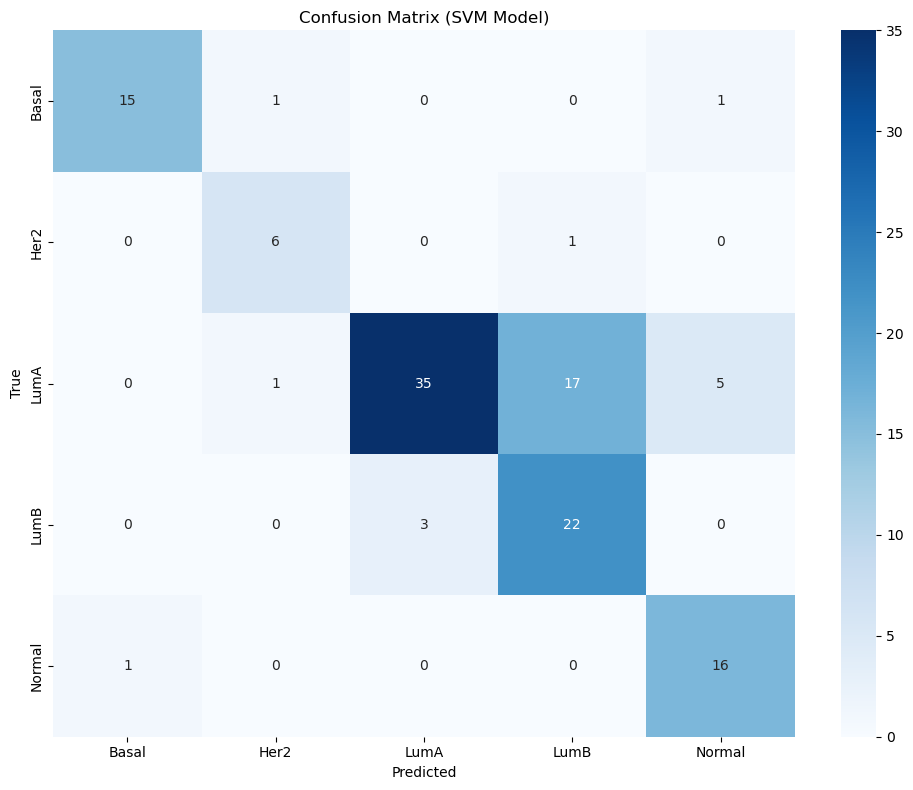

In [80]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()

In [13]:
pipelineSmote = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # Using SVC as the final classifier
])

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

param_dist = {
    'svm__C': loguniform(1e-3, 1e3),   
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': loguniform(1e-6, 1e-1)
}

rand = RandomizedSearchCV(
    estimator=pipelineSmote,
    param_distributions=param_dist,
    n_iter=50,                     # you decide budget
    scoring='f1_weighted',
    cv=3,
    n_jobs=10,
    verbose=3,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
best_model2 = rand.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'svm__C': 0.009808478272431488, 'svm__gamma': 1.1972422479639339e-06, 'svm__kernel': 'linear'}


In [32]:
import pandas as pd

results_df = pd.DataFrame(rand.cv_results_)

# sort by best score (RandomizedSearch stores mean test score column)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

top10 = results_df.head(10)

cols_to_show = ['mean_test_score', 'param_svm__C', 'param_svm__gamma', 'param_svm__kernel']
print(top10[cols_to_show])


    mean_test_score  param_svm__C  param_svm__gamma param_svm__kernel
35         0.791022      0.044497          0.000640            linear
42         0.787321      0.031315          0.000113            linear
3          0.784889      0.100520          0.000005            linear
0          0.784872      0.176702          0.056698            linear
21         0.784872      0.234910          0.042983            linear
48         0.784872     69.926361          0.030231            linear
45         0.784872      5.573452          0.000030            linear
41         0.784872      2.396919          0.003003            linear
38         0.784872      0.917854          0.000411            linear
30         0.784872     23.661540          0.007184            linear


In [51]:
# Evaluate the model on test data
y_pred = best_model2.predict(X_test)
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))


Test Accuracy (best model): 0.8225806451612904

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.94      0.94      0.94        17
        Her2       0.75      0.86      0.80         7
        LumA       0.85      0.81      0.83        58
        LumB       0.71      0.68      0.69        25
      Normal       0.80      0.94      0.86        17

    accuracy                           0.82       124
   macro avg       0.81      0.85      0.83       124
weighted avg       0.82      0.82      0.82       124



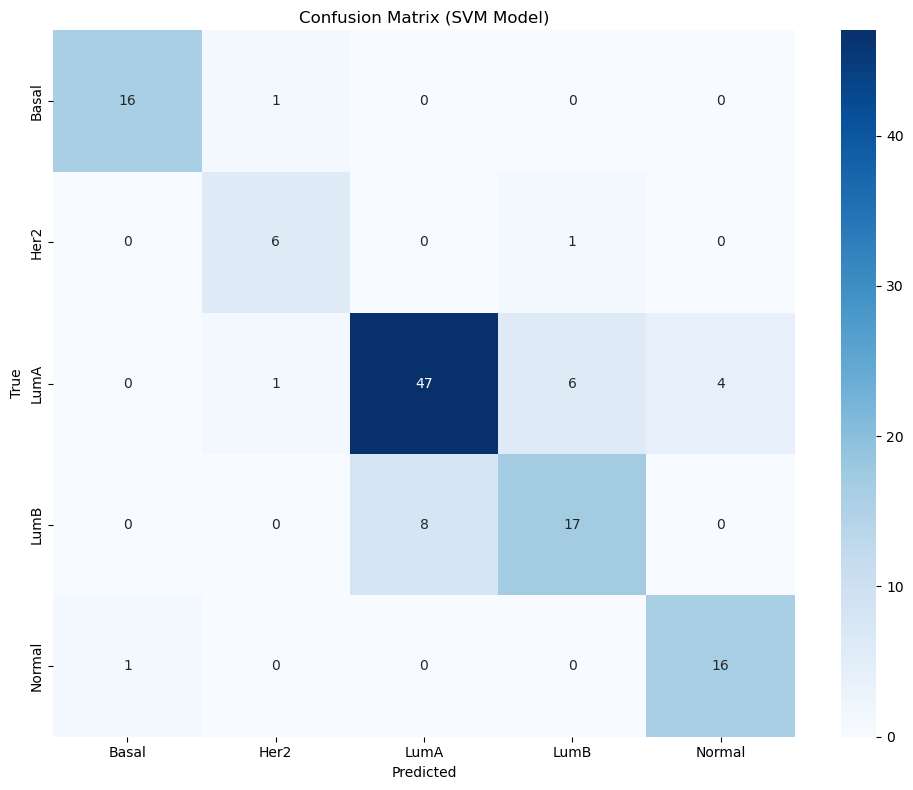

In [21]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()


Test Accuracy (best model): 0.717741935483871

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.94      0.94      0.94        17
        Her2       0.00      0.00      0.00         7
        LumA       0.64      0.95      0.76        58
        LumB       0.67      0.08      0.14        25
      Normal       0.89      0.94      0.91        17

    accuracy                           0.72       124
   macro avg       0.63      0.58      0.55       124
weighted avg       0.68      0.72      0.64       124



C:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


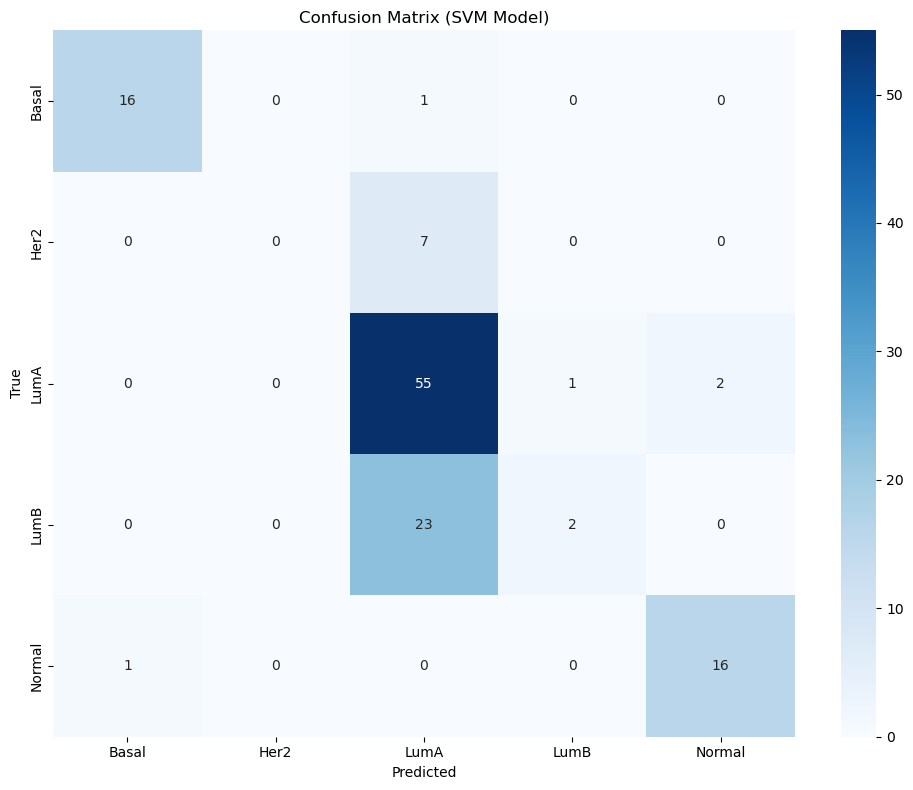

In [55]:
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svm_rbf.fit(X_train, y_train)

# Evaluate the model on test data

y_pred = svm_rbf.predict(X_test)
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()


Test Accuracy (best model): 0.8306451612903226

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.93      0.82      0.88        17
        Her2       0.75      0.86      0.80         7
        LumA       0.86      0.86      0.86        58
        LumB       0.74      0.68      0.71        25
      Normal       0.80      0.94      0.86        17

    accuracy                           0.83       124
   macro avg       0.82      0.83      0.82       124
weighted avg       0.83      0.83      0.83       124



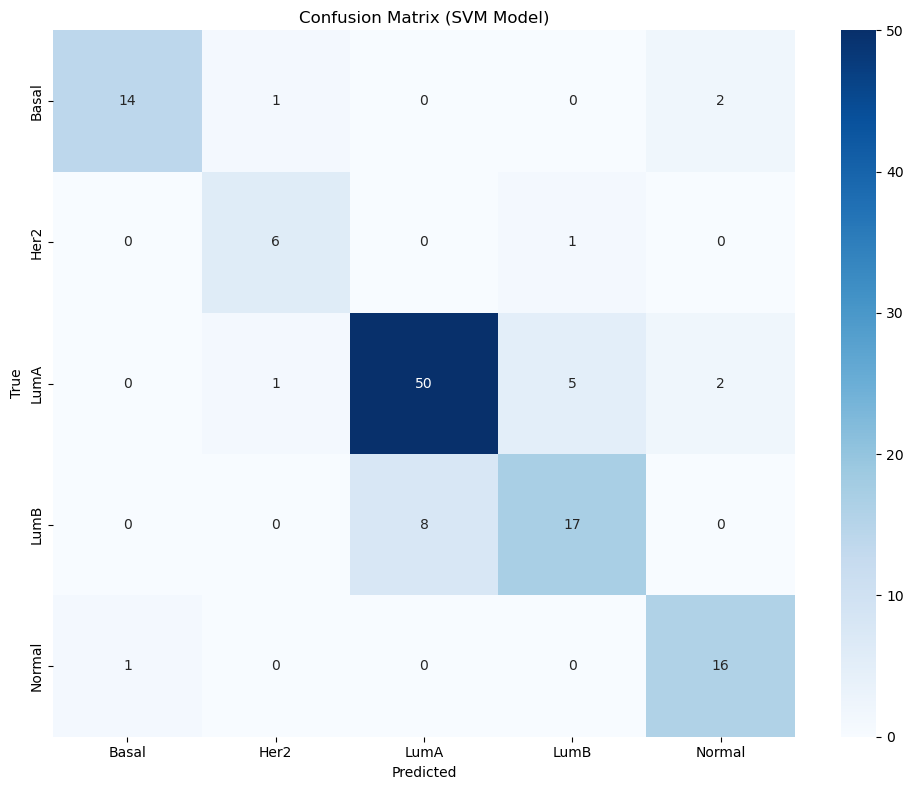

In [56]:
svm_linear = SVC(kernel='linear', probability=True, random_state=42)
svm_linear.fit(X_train, y_train)

# Evaluate the model on test data
y_pred = svm_linear.predict(X_test)
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()

In [34]:
pipelineSvm = ImbPipeline([
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # Using SVC as the final classifier
])


param_dist = {
    'svm__C': loguniform(1e-3, 1e3),   
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': loguniform(1e-6, 1e-1)
}

rand = RandomizedSearchCV(
    estimator=pipelineSvm,
    param_distributions=param_dist,
    n_iter=50,                     # you decide budget
    scoring='f1_weighted',
    cv=3,
    n_jobs=10,
    verbose=3,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
best_model3 = rand.best_estimator_



Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'svm__C': 0.04449700268707567, 'svm__gamma': 0.0006400547563489189, 'svm__kernel': 'linear'}


In [36]:
results_df = pd.DataFrame(rand.cv_results_)

# sort by best score (RandomizedSearch stores mean test score column)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

top10 = results_df.head(10)

cols_to_show = ['mean_test_score', 'param_svm__C', 'param_svm__gamma', 'param_svm__kernel']
print(top10[cols_to_show])


    mean_test_score  param_svm__C  param_svm__gamma param_svm__kernel
42         0.771033      0.031315          0.000113            linear
35         0.771033      0.044497          0.000640            linear
31         0.764563    361.247850          0.001800               rbf
3          0.761404      0.100520          0.000005            linear
0          0.761297      0.176702          0.056698            linear
21         0.761297      0.234910          0.042983            linear
48         0.761297     69.926361          0.030231            linear
45         0.761297      5.573452          0.000030            linear
41         0.761297      2.396919          0.003003            linear
38         0.761297      0.917854          0.000411            linear



Test Accuracy (best model): 0.8387096774193549

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.94      0.88      0.91        17
        Her2       0.75      0.86      0.80         7
        LumA       0.86      0.86      0.86        58
        LumB       0.74      0.68      0.71        25
      Normal       0.84      0.94      0.89        17

    accuracy                           0.84       124
   macro avg       0.83      0.84      0.83       124
weighted avg       0.84      0.84      0.84       124



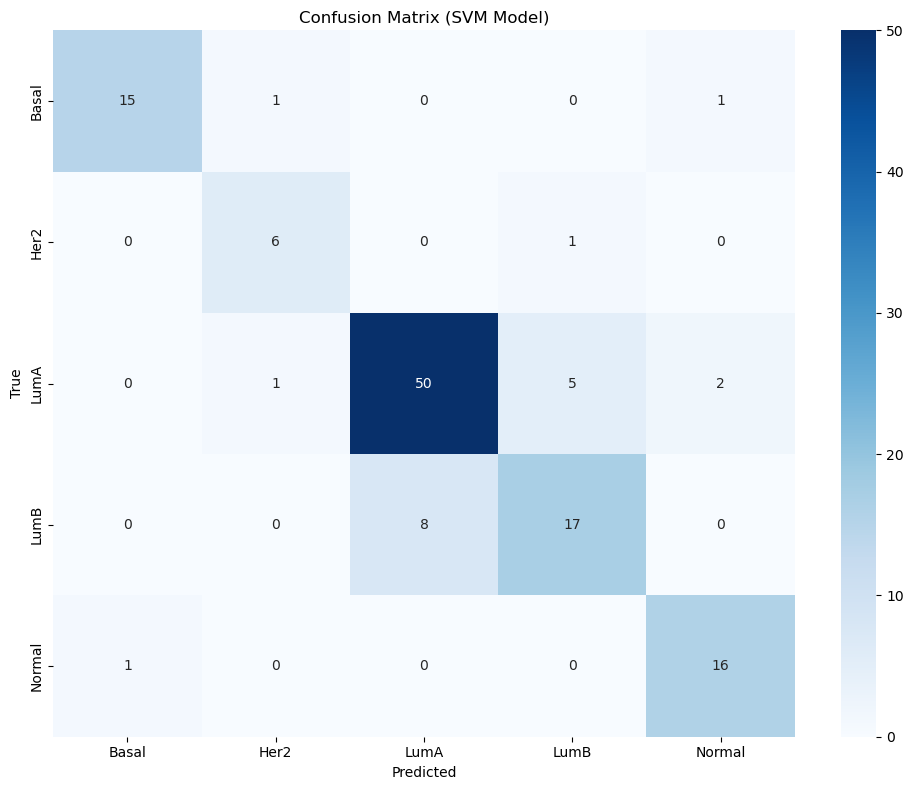

In [67]:

y_pred = best_model3.predict(X_test)
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()

In [69]:
pipelineSvmIrus = ImbPipeline([
    ('irus', RandomUnderSampler(sampling_strategy=irus_strategy, random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42)) # Using SVC as the final classifier
])

pipelineSvmIrus.fit(X_train, y_train)
y_pred = pipelineSvmIrus.predict(X_test)




Test Accuracy (best model): 0.6854838709677419

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.76      0.94      0.84        17
        Her2       0.00      0.00      0.00         7
        LumA       0.94      0.50      0.65        58
        LumB       0.45      0.96      0.62        25
      Normal       0.84      0.94      0.89        17

    accuracy                           0.69       124
   macro avg       0.60      0.67      0.60       124
weighted avg       0.75      0.69      0.67       124



C:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


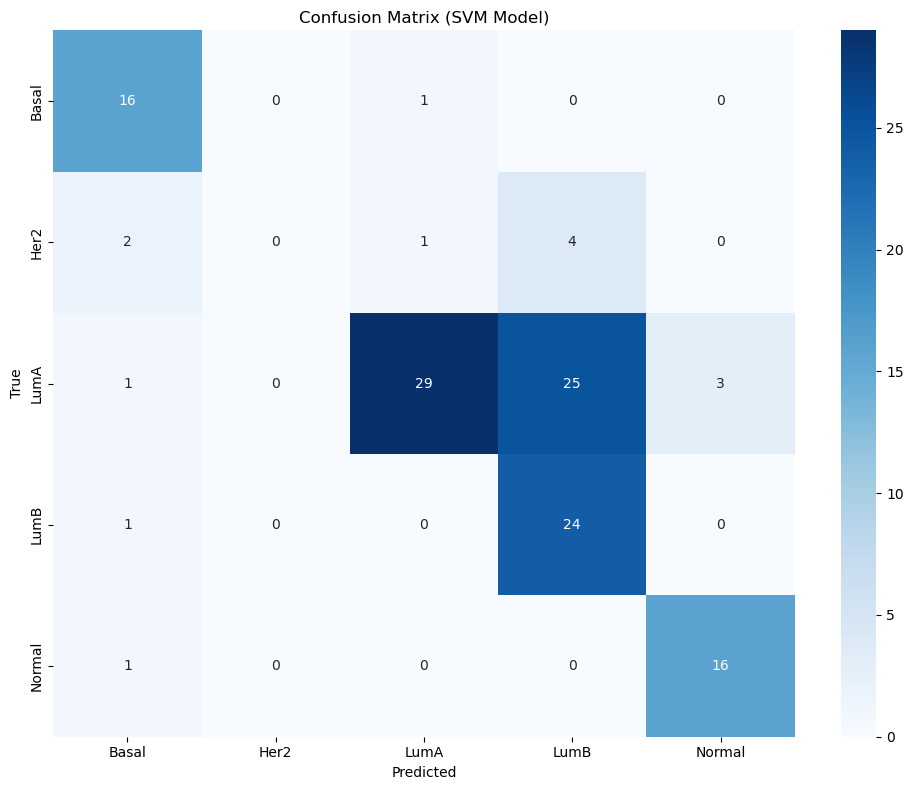

In [70]:
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()

In [73]:
pipelineSvmIrus = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42)) # Using SVC as the final classifier
])

pipelineSvmIrus.fit(X_train, y_train)
y_pred = pipelineSvmIrus.predict(X_test)




Test Accuracy (best model): 0.75

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.89      0.94      0.91        17
        Her2       0.55      0.86      0.67         7
        LumA       0.86      0.66      0.75        58
        LumB       0.53      0.68      0.60        25
      Normal       0.84      0.94      0.89        17

    accuracy                           0.75       124
   macro avg       0.73      0.81      0.76       124
weighted avg       0.78      0.75      0.75       124



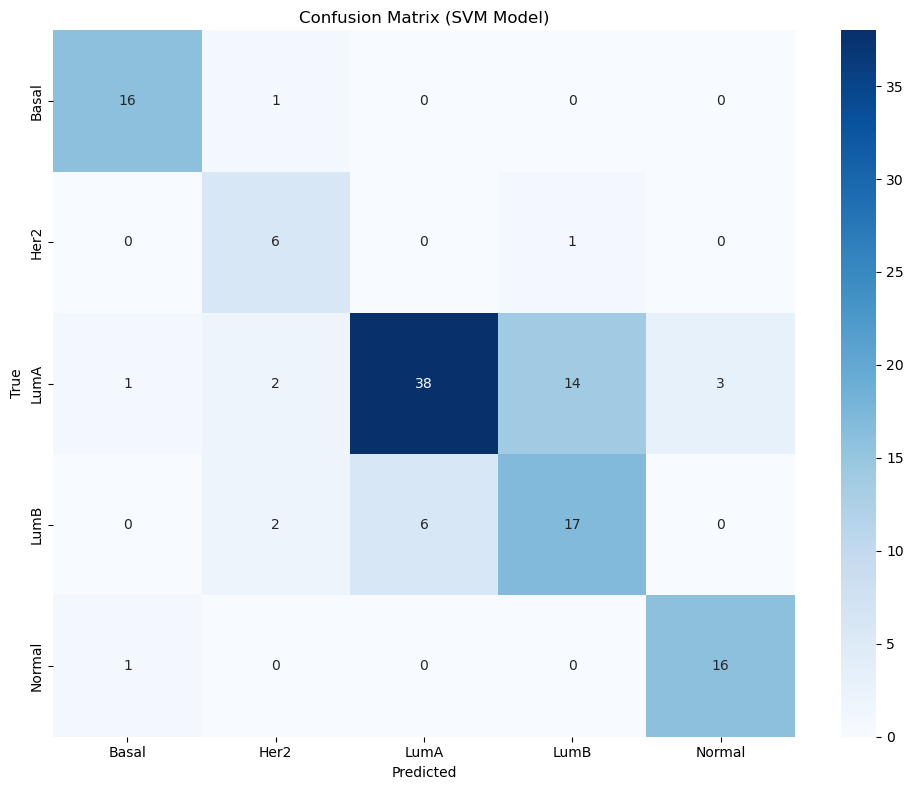

In [74]:
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()

In [47]:
from sklearn.feature_selection import RFE
pipelineSvm = ImbPipeline([
     ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False), 
                n_features_to_select=500, step=0.25, verbose=1)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # Using SVC as the final classifier
])


param_dist = {
    'svm__C': loguniform(1e-3, 1e3),   
    'svm__kernel': ['linear']
    #'svm__gamma': loguniform(1e-6, 1e-1)
}

rand = RandomizedSearchCV(
    estimator=pipelineSvm,
    param_distributions=param_dist,
    n_iter=50,                     # you decide budget
    scoring='f1_weighted',
    cv=2,
    n_jobs=15,
    verbose=3,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
best_model4 = rand.best_estimator_



Fitting 2 folds for each of 50 candidates, totalling 100 fits


KeyboardInterrupt: 

In [66]:
from sklearn.feature_selection import RFE
pipelineIrusRfe = ImbPipeline([
    ('irus', RandomUnderSampler(sampling_strategy=irus_strategy, random_state=42)),
    ('scaler', StandardScaler()),
    ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False), 
                n_features_to_select=500, step=0.25, verbose=1)),# SVMs benefit significantly from scaling
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # Using SVC as the final classifier
])

In [33]:
from sklearn.model_selection import ParameterGrid, cross_val_score
from tqdm import tqdm
from sklearn.base import clone

param_grid = { 
    'rfe__step': [0.2], 
    'svm__C': [0.1, 1, 10, 100],  # Regularization parameter
    'svm__kernel': ['linear'],  # Kernel types
}

grid = GridSearchCV(
    pipelineIrusRfe,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',  # ← USE THIS
    n_jobs=-1,
    verbose=3
)

# Run grid search on the original X_train/Y_train
grid.fit(X_train, y_train)

# Best parameters found
print("\nBest parameters found:")
print(grid.best_params_)

# Best model
best_model5 = grid.best_estimator_


NameError: name 'pipelineIrusRfe' is not defined

In [69]:
# Evaluate the model on test data
y_pred = best_model5.predict(X_test)
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))


Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.57      0.67      0.62        18
        Her2       0.40      0.33      0.36         6
        LumA       0.82      0.57      0.67        58
        LumB       0.40      0.56      0.47        25
      Normal       0.65      0.88      0.75        17

    accuracy                           0.61       124
   macro avg       0.57      0.60      0.57       124
weighted avg       0.66      0.61      0.62       124



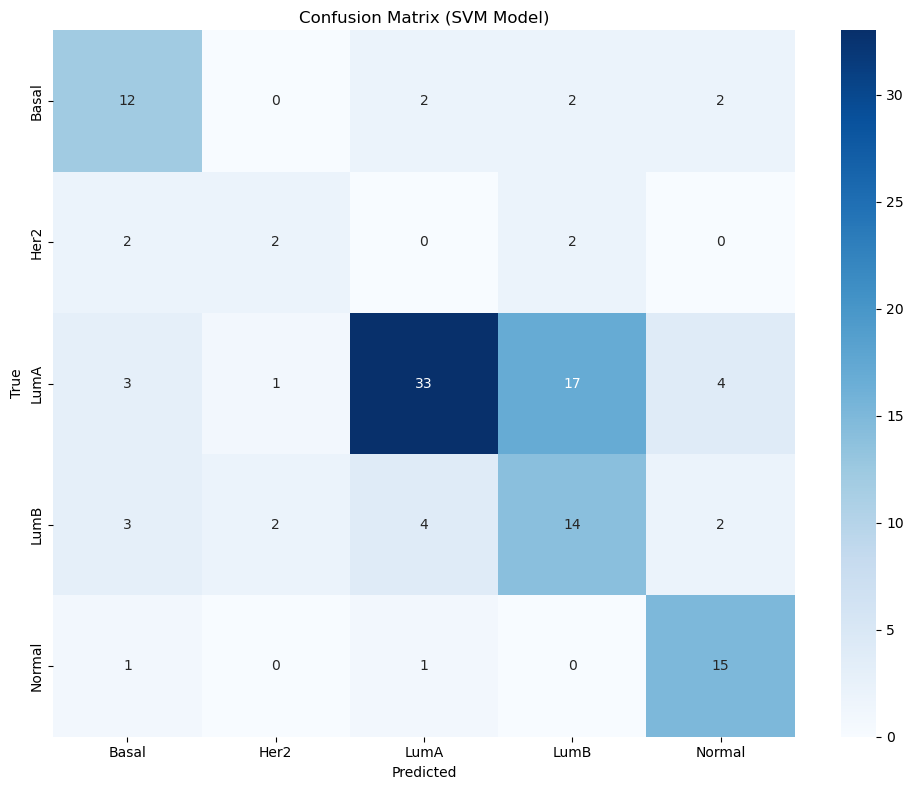

In [70]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_selection import RFE
pipelineNoImb = ImbPipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # Using SVC as the final classifier
])

In [ ]:
from sklearn.model_selection import ParameterGrid, cross_val_score
from tqdm import tqdm
from sklearn.base import clone

param_grid = { 
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['rbf'],
    'svm__gamma': [0.001, 0.01, 0.1, 1]
}

grid = GridSearchCV(
    pipelineNoImb,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',  # ← USE THIS
    n_jobs=-1,
    verbose=3
)

# Run grid search on the original X_train/Y_train
grid.fit(X_train, y_train)

# Best parameters found
print("\nBest parameters found:")
print(grid.best_params_)

# Best model
best_model6 = grid.best_estimator_


In [ ]:
# Evaluate the model on test data
y_pred = best_model6.predict(X_test)
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))